# AI Learns to Play Connect 4
#### Jordan Yeomans - 2018

## Part 5 - Building A Neural Network In Tensorflow

### What's Next?

- Currently we have a code that can organise all of the recorded games of a random vs random bot playing. 
- We have stored all of the winning games and we now want to build a neural network that can predict the next move of the winning player, given a certain board.

- We could use a high level framework like Keras for this, which I would recommend as something fun to do. It would certainly be faster. Personally, my aim is to become a world-class AI engineer/researcher and I believe becoming an expert at frameworks like Tensorflow is probably a better long term approach.

So what's the approach?

1. Load Data
2. Perform a tiny amount of data processing
3. Create Neural Network
4. Create Loss Function and Evaluation Metric
5. Train Network
6. Evaluate the Network
7. See if it works! (Part 6)

#### Step 1 - Load Data

At this point, I recorded around 12,000 individual games of the random vs random bot. I then used the code in Part 4 to organise them into a single array. Let's load that now



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

# Copy and Paste from Previous Sections
def plot_winner_board(board):
    plt.figure()
    for row in range(board.shape[0]):
        for col in range(board.shape[1]):
            if board[5-row][col] == 1:
                plt.scatter(col, row, c='Blue', s=500, edgecolors='black')

            if board[5-row][col] == -1:
                plt.scatter(col, row, c='Black', s=500, edgecolors='black')
    plt.grid()
    plt.ylim(-1, 6)
    plt.xlim(-1, 7)
    plt.show()
    plt.close()

# NN Parameters
lr = 0.0001
epochs = 200
val_split = 0.1
eval_split = 0.05
batch_size = 1024

# Folder Paths
data_load_folder = 'C:/Users/Jordan Yeomans/Documents/GitHub/RiddlesIO/four_in_a_row/Data/Processed_Data/Random_vs_Random/'
nn_save_folder = 'C:/Users/Jordan Yeomans/Documents/GitHub/RiddlesIO/four_in_a_row/NeuralNetworks/AI_Bot_Version_1/'

# Load Data
move_history_input = np.load(data_load_folder + 'input_data.npy')
move_history_output = np.load(data_load_folder + 'output_data.npy')

# Check Number Of Samples
print('Input Data Shape = {}:'.format(move_history_input.shape))
print('Output Data Shape = {}:'.format(move_history_output.shape))

c:\users\jordan yeomans\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Input Data Shape = (55034, 6, 7):
Output Data Shape = (55034, 7, 1):


#### Step 2 - Data Processing

Although we have all of the data in a single file, we need to do a tiny bit of data processing. 

1. We need to remove the last dimension of the output data. We didn't really need to include this in the first place, but since we did it's easy to remove
2. We need to split the data into a Training set, Validation set and Evaluation set

The training set will use used by the back propogation algorithm to learn what weights/biases in the network reduce the loss function.

The Validation set will be used to ensure that "un-seen" data is also being learned on

Finally, we keep some data as an evaluation set for a final check so ensure we haven't designed an architecture or over optimised hyperparameters to bias a result that only works on the validation set.

To split the data, we will make a function that we can use again in the future:

1. Calculate the number of training/validation and evaluation samples
2. Create an array from 0 -> total number of samples
3. Randomly shuffle the index's (Just the array we created, not the actual data)
4. Assign training/validation/evaluation index's (Notice these are shuffled index's)
5. Create Training/Validation/Evaluation Data by assigning the data from Move_History at each index
6. Print the results as a check

Training Samples = 46780, Validation Samples = 5503, Evaluation Samples = 2751

Example Output #9:
  [0. 1. 0. 0. 0. 0. 0.]

Example Input #9:


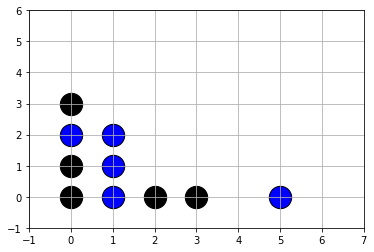

In [2]:
# Reshape output to shape (7, )
move_history_output = move_history_output.reshape(move_history_output.shape[0], move_history_output.shape[1])


def split_data(move_history_input, move_history_output, val_split, eval_split):

    # Calculate the number of training/validation and evaluation samples
    num_val = int(move_history_input.shape[0] * val_split)
    num_eval = int(move_history_input.shape[0] * eval_split)
    num_train = move_history_input.shape[0] - num_val - num_eval

    # Create an array from 0 -> total number of samples
    all_idx = np.arange(0, move_history_input.shape[0], 1)

    # Randomly shuffle the index's (Just the array we created, not the actual data)
    np.random.shuffle(all_idx)

    # Assign training/validation/evaluation index's
    train_idx = all_idx[:num_train]
    val_idx = all_idx[num_train: num_train + num_val]
    eval_idx = all_idx[num_train + num_val:]

    # Create Training/Validation/Evaluation Data by assigning the data from Move_History at each index
    train_input_data, train_output_data = move_history_input[train_idx], move_history_output[train_idx]
    val_input_data, val_output_data = move_history_input[val_idx], move_history_output[val_idx]
    eval_input_data, eval_output_data = move_history_input[eval_idx], move_history_output[eval_idx]
    
    print('Training Samples = {}, Validation Samples = {}, Evaluation Samples = {}'.format(train_input_data.shape[0], val_input_data.shape[0], eval_input_data.shape[0]))
    return train_input_data, train_output_data, val_input_data, val_output_data, eval_input_data, eval_output_data


# Split data into training, validation and evaluation
train_in_data, train_out_data, val_in_data, val_out_data, eval_in_data, eval_out_data = split_data(move_history_input, move_history_output, val_split, eval_split)

# Look at an example Input/Output
example_num = 9
print('\nExample Output #{}:\n  {}'.format(example_num, move_history_output[example_num]))
print('\nExample Input #{}:'.format(example_num))
plot_winner_board(move_history_input[example_num])

We can see that in this position, a token in the column with index = 1 is going to win the game. Definitely a good move!

#### Step 3 - Create Neural Network

Here is the fun part, making a neural network!

Let's start simple with a 3-layer fully connected network. We will look into Convolutional Networks later but we will start with the basics for now

1. Create some Placeholders:  x will be used to feed the input data, y will be used to feed the output data

2. Create the Network: Follow the comments in the following code

##### Activation Functions: 

We have added a Relu activation to the fully connected layers while not including any activation on the final layer. This is because the loss function we will be using internally applies an activation function and we don't want to apply it twice.

##### What Is A Placeholder And What Is A Tensor?

If you're searching for an official explaination for what a tensor is, it's best to Google an official tutorial. But the way I try to wrap my head around it is:

- A tensor is kind of like a pre-allocated equation. We are just saying "Hey computer, remember this equation. When I have some more information I want you calculate the result based on this equation".


- Remember, at this point we haven't told it what data to use. We have just said, "When we do, here is what we want you to calculate"


- So how do the placeholders help? - Well, that is our way to telling the computer what sort of data it can expect when we finally give it that data. It's just a heads up - Something like: "Im not sure how many input examples I'll give you (None), But they will all be of size (6,7)


In [3]:
# Create Placeholders
x = tf.placeholder(tf.float32, shape=[None, 6, 7], name='input_placeholder')
y = tf.placeholder(tf.float32, shape=[None, 7], name='output_placeholder')

# Create Network
nn = tf.layers.flatten(x, name='input')                 # Flatten Board
nn = tf.layers.dense(nn, 256, activation=tf.nn.relu)    # Layer 1 - Fully Connected with 256 Nodes
nn = tf.layers.dense(nn, 256, activation=tf.nn.relu)    # Layer 2 - Fully Connected with 256 Nodes
nn = tf.layers.dense(nn, 256, activation=tf.nn.relu)    # Layer 3 - Fully Connected with 256 Nodes
last_layer = tf.layers.dense(nn, 7, name='output')      # Output Layer


print(x)
print(y)
print(last_layer)

Tensor("input_placeholder:0", shape=(?, 6, 7), dtype=float32)
Tensor("output_placeholder:0", shape=(?, 7), dtype=float32)
Tensor("output/BiasAdd:0", shape=(?, 7), dtype=float32)


#### Step 4 - Create A Loss Function, Optimiser & Evaluation Metric

##### Loss Function:
We have defined this problem as a classification problem: "Which column should we place the token in"

This is something Neural Networks are really good at. We can use the softmax_cross_entropy_with_logits_v2 function built into tensorflow. Since it is asking for logits, the function wants raw output of the last layer without an activation applied.

##### Optimiser:
For the optimiser we are using the Adam optimiser

##### Evaluation Metric:
When we train the network, we will have the loss returned as a number. This doesn't really mean too much, we would like to know how accurate the predictions are. I got this from Stack Overflow a few weeks ago

1. We create a tensor (Remember, this is like allocating an equation) to evaluate if the index of the argmax of the predicted output is equal to the argmax of the true output

2. We create a tensor (New preset equation!) to evaluate the proportion of correct answers

In [4]:
# Define Loss Function
loss_function = tf.nn.softmax_cross_entropy_with_logits_v2(logits=last_layer, labels=y)
loss = tf.reduce_mean(loss_function)

# Create Optimiser
learning_step = tf.train.AdamOptimizer(lr)
optimiser = learning_step.minimize(loss)

# Create Accuracy Evaluation
correct = tf.equal(tf.argmax(last_layer, axis=1), tf.argmax(y, axis=1))
acc = tf.reduce_mean(tf.cast(correct, 'float'))

We are almost there! Just before we do, we need to be able to split our training data into batches. This is for a few reasons:

1. There are practical limits to how many calculations your computer can do are once. This will depend on the type of data and how much memory you have
2. There are performance increases by modifying the batch size. 1024 seems to be quite a common number, if you can fit that much into the memory

Note: For Deep Learning you really want to have a good NVIDIA Graphics Card that can use the CUDA toolkit. I am using at GTX1080ti although you don't need to go that extreme! This project will probably work on a CPU, I haven't tried, let me know if it does

In [5]:
def split_into_batches(train_in_data, train_out_data, batch_size):

    num_batches = int(np.floor(train_in_data.shape[0]/batch_size))

    train_in_batches = np.zeros((num_batches, batch_size, train_in_data.shape[1], train_in_data.shape[2]))
    train_out_batches = np.zeros((num_batches, batch_size, train_out_data.shape[1]))

    samples = np.arange(0, num_batches * batch_size, step=1)
    np.random.shuffle(samples)

    for i in range(train_in_batches.shape[0]):
        start_num = i * batch_size
        end_num = start_num + batch_size

        batch_samples = samples[start_num:end_num]

        train_in_batches[i] = train_in_data[batch_samples]
        train_out_batches[i] = train_out_data[batch_samples]

    return train_in_batches, train_out_batches

#### Step 5 - Train Network

Woohoo! The fun part! It's a bit of a mission to get this far!

Let's make sure we can save the network. We can create a saver object with tf.train.Saver(). Also we will need to keep a copy of the best accuracy so we know to save the best network

##### What is a Session?

Again, if you're after an official explaination it's best to Google it. But here is my take:

1. A session is an object that we use to run the network. While we are in the session, we can pass in variables and make calculations and the network will remember all of the parameters.
2. As soon as we leave the session, all parameters are forgotten. So it is the session object that is storing the parameters being calculated.

So what does that mean?

- Any calculations need to be performed in a session
- Any evaluations need to be performed in the "same" session (OR) Loaded from a saved session
- As soon as you jump out of the session, the parameters (Weights/Biases etc) will be forgotten!!!! So we need to save them to disk

##### What's Happening?

1. Before we do anything, we need to initialise all variables.
2. Iterate over all epochs
3. For each epoch, we will split all of the training data into batches
4. We can now iterate over each batch
5. The magic line is *
6. After all batches have been calculated we can evaluate the training and validation accuracy
7. If we have improved the validation accuracy, we should save the model
8. We can print the results every 50 epochs to keep a track of the progress
9. After all epochs are complete, we can load the best model with saver.restore()
10. We should evaluate the model using the evaluation data (It hasn't seen this yet!) to make sure the validation and evaluation prediction accuracy is similar

###### * _, batch_cost = sess.run([optimiser, loss], feed_dict={x: train_in_batches[batch], y: train_out_batches[batch]})

- The line above is running the network for 1 step. 
- During that step, it takes the current input batch and says "Here is the x data you're expecting". The output data for that batch is fed to the network in place of the y placeholder
- This is repeated for each batch, before moving onto the next epoch


In [6]:
# Create Saver
saver = tf.train.Saver()
best_acc = 0

# Train Network
with tf.Session() as sess:

    # Initialise Variables
    sess.run(tf.global_variables_initializer())
    
    epoch_train_acc = sess.run(acc, feed_dict={x: train_in_data, y: train_out_data})
    epoch_val_acc = sess.run(acc, feed_dict={x: val_in_data, y: val_out_data})
    
    print('Randomly Initialised Weight/Biases: Train Acc = {:.3f}%, Val Acc = {:.3f}%'.format(epoch_train_acc * 100, epoch_val_acc * 100))

    # Iterate over all Epochs
    for epoch in range(epochs):

        # Split training data into batches
        train_in_batches, train_out_batches = split_into_batches(train_in_data, train_out_data, batch_size)

        # Iterate over all batches
        for batch in range(train_in_batches.shape[0]):

            _, batch_cost = sess.run([optimiser, loss], feed_dict={x: train_in_batches[batch], y: train_out_batches[batch]})

        # Evaluate Training and Validation Accuracy
        epoch_train_acc = sess.run(acc, feed_dict={x: train_in_data, y: train_out_data})
        epoch_val_acc = sess.run(acc, feed_dict={x: val_in_data, y: val_out_data})

        # Save model if it is an improvement
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            saver.save(sess, nn_save_folder)
        
        # Print results every 50 epochs
        if epoch < 10 or epoch % 25 == 0:
            print('After {} Epochs: Single Batch Cost = {:.3f}, Train Acc = {:.3f}%, Val Acc = {:.3f}%'.format(epoch+1, batch_cost, epoch_train_acc * 100, epoch_val_acc * 100))

    # Load Saved Session
    saver.restore(sess, nn_save_folder)

    # After Training, Check Evaluation Accuracy
    eval_acc = sess.run(acc, feed_dict={x: eval_in_data, y: eval_out_data})
    print('Evaluation Acc = {:.3f}%'.format(eval_acc * 100))

Randomly Initialised Weight/Biases: Train Acc = 14.213%, Val Acc = 15.137%
After 1 Epochs: Single Batch Cost = 1.849, Train Acc = 36.838%, Val Acc = 36.398%
After 2 Epochs: Single Batch Cost = 1.721, Train Acc = 41.830%, Val Acc = 41.904%
After 3 Epochs: Single Batch Cost = 1.642, Train Acc = 43.189%, Val Acc = 42.886%
After 4 Epochs: Single Batch Cost = 1.503, Train Acc = 45.222%, Val Acc = 45.157%
After 5 Epochs: Single Batch Cost = 1.484, Train Acc = 46.905%, Val Acc = 46.575%
After 6 Epochs: Single Batch Cost = 1.455, Train Acc = 47.657%, Val Acc = 46.793%
After 7 Epochs: Single Batch Cost = 1.381, Train Acc = 48.138%, Val Acc = 46.920%
After 8 Epochs: Single Batch Cost = 1.338, Train Acc = 48.440%, Val Acc = 46.684%
After 9 Epochs: Single Batch Cost = 1.359, Train Acc = 48.623%, Val Acc = 47.192%
After 10 Epochs: Single Batch Cost = 1.329, Train Acc = 48.957%, Val Acc = 46.938%
After 26 Epochs: Single Batch Cost = 1.256, Train Acc = 51.526%, Val Acc = 48.301%
After 51 Epochs: Sing

#### Awesome! 

It seems to have learnt something! 

At first with randomly initialised weights we got an accuracy of around 14%. This makes sense since random guess has a 1/7 chance of being right = 14.3%

As the network was trained we can see the accuracy increased to over 50%. It is going to be harder to get much more than this as in early game moves (say less than 4 pieces on the board) any move is probably equally good.

It's also good to see the Validation and Evaluation predictions accuracy is similar. Also notice the training accuracy is close to 60%. Possibly the model is overfitting. We could experiment with techniques such as dropout but for now we will see if this bot works even a little bit!

Let's see if we can put this into practice! Part 6: Implementing AI V1 is next 

As always, here is the complete code.

Ignore the error at the bottom. It doesn't like it when you recreate a tensor with the same name!

Input Data Shape = (55034, 6, 7):
Output Data Shape = (55034, 7, 1):
[0. 1. 0. 0. 0. 0. 0.]


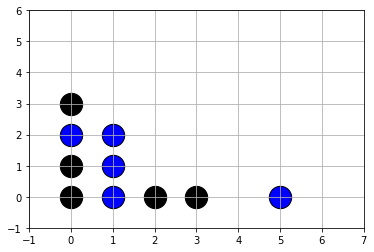

Training Samples = 46780, Validation Samples = 5503, Evaluation Samples = 2751


ValueError: Variable output/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "c:\users\jordan yeomans\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "c:\users\jordan yeomans\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "c:\users\jordan yeomans\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

def split_data(move_history_input, move_history_output, val_split, eval_split):

    # Calculate the number of training/validation and evaluation samples
    num_val = int(move_history_input.shape[0] * val_split)
    num_eval = int(move_history_input.shape[0] * eval_split)
    num_train = move_history_input.shape[0] - num_val - num_eval

    # Create an array from 0 -> total number of samples
    all_idx = np.arange(0, move_history_input.shape[0], 1)

    # Randomly shuffle the index's (Just the array we created, not the actual data)
    np.random.shuffle(all_idx)

    # Assign training/validation/evaluation index's
    train_idx = all_idx[:num_train]
    val_idx = all_idx[num_train: num_train + num_val]
    eval_idx = all_idx[num_train + num_val:]

    # Create Training/Validation/Evaluation Data by assigning the data from Move_History at each index
    train_input_data, train_output_data = move_history_input[train_idx], move_history_output[train_idx]
    val_input_data, val_output_data = move_history_input[val_idx], move_history_output[val_idx]
    eval_input_data, eval_output_data = move_history_input[eval_idx], move_history_output[eval_idx]

    print('Training Samples = {}, Validation Samples = {}, Evaluation Samples = {}'.format(train_input_data.shape[0], val_input_data.shape[0], eval_input_data.shape[0]))
    return train_input_data, train_output_data, val_input_data, val_output_data, eval_input_data, eval_output_data

def split_into_batches(train_in_data, train_out_data, batch_size):

    num_batches = int(np.floor(train_in_data.shape[0]/batch_size))

    train_in_batches = np.zeros((num_batches, batch_size, train_in_data.shape[1], train_in_data.shape[2]))
    train_out_batches = np.zeros((num_batches, batch_size, train_out_data.shape[1]))

    samples = np.arange(0, num_batches * batch_size, step=1)
    np.random.shuffle(samples)

    for i in range(train_in_batches.shape[0]):
        start_num = i * batch_size
        end_num = start_num + batch_size

        batch_samples = samples[start_num:end_num]

        train_in_batches[i] = train_in_data[batch_samples]
        train_out_batches[i] = train_out_data[batch_samples]

    return train_in_batches, train_out_batches

# Folder Paths
data_load_folder = 'C:/Users/Jordan Yeomans/Documents/GitHub/RiddlesIO/four_in_a_row/Data/Processed_Data/Random_vs_Random/'
nn_save_folder = 'C:/Users/Jordan Yeomans/Documents/GitHub/RiddlesIO/four_in_a_row/NeuralNetworks/AI_Bot_Version_1/'

# NN Parameters
lr = 0.0001
epochs = 1000
val_split = 0.1
eval_split = 0.05
batch_size = 1024

# Load Data
move_history_input = np.load(data_load_folder + 'input_data.npy')
move_history_output = np.load(data_load_folder + 'output_data.npy')

# Check Number Of Samples
print('Input Data Shape = {}:'.format(move_history_input.shape))
print('Output Data Shape = {}:'.format(move_history_output.shape))

# Reshape output to shape (7, )
move_history_output = move_history_output.reshape(move_history_output.shape[0], move_history_output.shape[1])

# Look at an example Input/Output
print(move_history_output[9])
plot_winner_board(move_history_input[9])

# Split data into training, validation and evaluation
train_in_data, train_out_data, val_in_data, val_out_data, eval_in_data, eval_out_data = split_data(move_history_input, move_history_output, val_split, eval_split)

# Create Placeholders
x = tf.placeholder(tf.float32, shape=[None, 6, 7], name='input_placeholder')
y = tf.placeholder(tf.float32, shape=[None, 7], name='output_placeholder')

# Create Network
nn = tf.layers.flatten(x, name='input')                 # Flatten Board
nn = tf.layers.dense(nn, 256, activation=tf.nn.relu)    # Layer 1 - Fully Connected with 256 Nodes
nn = tf.layers.dense(nn, 256, activation=tf.nn.relu)    # Layer 2 - Fully Connected with 256 Nodes
nn = tf.layers.dense(nn, 256, activation=tf.nn.relu)    # Layer 3 - Fully Connected with 256 Nodes
last_layer = tf.layers.dense(nn, 7, name='output')      # Output Layer

# Define Loss Function
loss_function = tf.nn.softmax_cross_entropy_with_logits_v2(logits=last_layer, labels=y)
loss = tf.reduce_mean(loss_function)

# Create Optimiser
learning_step = tf.train.AdamOptimizer(lr)
optimiser = learning_step.minimize(loss)

# Create Accuracy Evaluation
correct = tf.equal(tf.argmax(last_layer, axis=1), tf.argmax(y, axis=1))
acc = tf.reduce_mean(tf.cast(correct, 'float'))

# Create Saver
saver = tf.train.Saver()
best_acc = 0

# Train Network
with tf.Session() as sess:

    # Initialise Variables
    sess.run(tf.global_variables_initializer())

    # Iterate over all Epochs
    for epoch in range(epochs):

        # Split training data into batches
        train_in_batches, train_out_batches = split_into_batches(train_in_data, train_out_data, batch_size)

        # Iterate over all batches
        for batch in range(train_in_batches.shape[0]):

            _, batch_cost = sess.run([optimiser, loss], feed_dict={x: train_in_batches[batch], y: train_out_batches[batch]})

        # Evaluate Training and Validation Accuracy
        epoch_train_acc = sess.run(acc, feed_dict={x: train_in_data, y: train_out_data})
        epoch_val_acc = sess.run(acc, feed_dict={x: val_in_data, y: val_out_data})

        # Save model if it is an improvement
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            saver.save(sess, nn_save_folder)
            print('Saved Model')

        # Print results every 10 epochs
        if epoch % 10 == 0:
            print('Single Batch Cost = {:.3f}, Train Acc = {:.3f}%, Val Acc = {:.3f}%'.format(batch_cost, epoch_train_acc * 100, epoch_val_acc * 100))

    # Load Saved Session
    saver.restore(sess, nn_save_folder)

    # After Training, Check Evaluation Accuracy
    eval_acc = sess.run(acc, feed_dict={x: eval_in_data, y: eval_out_data})
    print('Evaluation Acc = {:.3f}%'.format(eval_acc * 100))